# Восстановление золота из руды

Подготовка прототипа модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используются данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Импорт и настройки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)


RANDOM_STATE = 12345
TEST_RATIO = .25

## Подготовка данных

### Загрузка и обзор данных

In [2]:
links = ['/datasets/gold_recovery_train_new.csv',
         '/datasets/gold_recovery_test_new.csv',
         '/datasets/gold_recovery_full_new.csv']
dfs = {}

for link in links:
    name = link.split('gold_recovery_')[1].split('_new')[0]
    try:
        dfs[name] = pd.read_csv(link)
        print('Загружен датасет', name)
    except:
        print('Data source unreachable')

Загружен датасет train
Загружен датасет test
Загружен датасет full


In [3]:
for name in dfs:
    print('\nДатасет', name, end='\n\n')
    dfs[name].info(verbose=False)
    print('\nПропуски', end='\n\n')
    print(dfs[name].isna().sum().sort_values(ascending=False).head())
    display(dfs[name].head(3))

print('\n Столбцы\n')
sorted(dfs['full'].columns)


Датасет train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Columns: 87 entries, date to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(86), object(1)
memory usage: 9.4+ MB

Пропуски

secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
dtype: int64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.


Датасет test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Columns: 53 entries, date to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(52), object(1)
memory usage: 2.1+ MB

Пропуски

rougher.input.floatbank11_xanthate          25
rougher.input.feed_sol                      21
secondary_cleaner.state.floatbank3_a_air     9
rougher.input.floatbank11_sulfate            8
primary_cleaner.input.depressant             5
dtype: int64


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559



Датасет full

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Columns: 87 entries, date to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(86), object(1)
memory usage: 12.9+ MB

Пропуски

secondary_cleaner.output.tail_sol           1748
rougher.input.floatbank11_xanthate           453
rougher.state.floatbank10_e_air              436
primary_cleaner.output.concentrate_sol       370
secondary_cleaner.state.floatbank2_a_air     220
dtype: int64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.


 Столбцы



['date',
 'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.s

Исходный датасет full разбит на train и test.  
В данных присутствуют пропуски.

## Предобработка

Сохраним датасеты в переменные для удобства.

In [4]:
df_train = dfs['train']
df_test = dfs['test']
df_full = dfs['full']

### Аномальные значения

Проверим наличие нулей в целевых показателях

In [5]:
df_full[df_full['final.output.recovery'] == 0].shape[0], df_full[df_full['rougher.output.recovery'] == 0].shape[0]

(98, 394)

В формуле рассчета рекавери используется множитель концентрации после очистки, проверим эти значения.

In [6]:
(((df_full['final.output.concentrate_au'] == 0) & (df_full['final.output.recovery'] == 0)).sum(),
((df_full['rougher.output.concentrate_au'] == 0) & (df_full['rougher.output.recovery'] == 0)).sum())

(98, 394)

Проверим также концентрацию золота после первой очистки

In [7]:
(df_full['primary_cleaner.output.concentrate_au'] == 0).sum()

108

Концентрации не могут быть равны нулю во время нормального техпроцесса. Это либо нарушения техпроцесса, либо ошибки в записи. Для обучения моделей эти данные будут помехой, так как записей немного, то удалим их.

In [8]:
zeros = ((df_full['rougher.output.concentrate_au'] == 0) |
         (df_full['final.output.concentrate_au'] == 0) |
         (df_full['primary_cleaner.output.concentrate_au'] == 0))
zeros_dates = df_full[zeros]['date']
train_zeros = df_train['date'].isin(zeros_dates)
test_zeros = df_test['date'].isin(zeros_dates)
df_train = df_train[~train_zeros]
df_test = df_test[~test_zeros]
df_full = df_full[~zeros]

Другие значения также не должны обращаться в нуль, заменим их пропусками.

In [9]:
df_train.replace(to_replace=0, value=np.nan, inplace=True)
df_test.replace(to_replace=0, value=np.nan, inplace=True)

### Замена индексов

Все признаки числовые кроме даты. Для удобства работы сделаем столбец даты индексом. Так у нас все столбцы будут числовыми и мы не потеряем дату.

In [10]:
for df in [df_train, df_test, df_full]:
    df.set_index('date', inplace=True)

### Пропуски

Так как данные записывались каждый час, то заполним пропуски средним значением от соседних ячеек.

In [11]:
df_train = df_train.interpolate(method='linear')
df_test = df_test.interpolate(method='linear')
df_train.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0)

### Подготовка данных для обучения

На момент предсказания rougher.output.recovery у нас нет данных с последующих этапов поэтому берем данные только с флотации.

In [12]:
rouger_features = [
    'rougher.input.feed_ag',
    'rougher.input.feed_au',
    'rougher.input.feed_pb',
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    'rougher.input.feed_sol',
    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate',
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_air',
    'rougher.state.floatbank10_f_level'
]

In [13]:
train_rougher = df_train[rouger_features]
train_final = df_train[df_test.columns]
train_target_rougher = df_full.loc[train_rougher.index, 'rougher.output.recovery']
train_target_final = df_full.loc[train_final.index, 'final.output.recovery']
test_rogher = df_test[rouger_features]
test_final = df_test
test_target_rougher = df_full.loc[test_rogher.index, 'rougher.output.recovery']
test_target_final = df_full.loc[test_final.index, 'final.output.recovery']

In [14]:
train_rougher.shape, train_final.shape, train_target_rougher.shape, train_target_final.shape

((13725, 22), (13725, 52), (13725,), (13725,))

In [15]:
test_rogher.shape, test_final.shape, test_target_rougher.shape, test_target_final.shape

((5123, 22), (5123, 52), (5123,), (5123,))

## Анализ данных

### Проверка рассчета recovery

Проверим правильность рассчета recovery на этапе rougher. Используем формулу

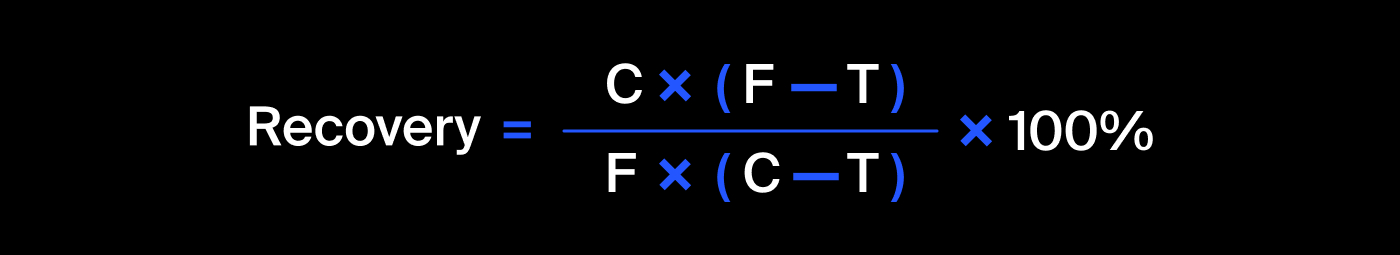

где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

In [16]:
def recovery(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    return 100 * c * (f - t) / (
              f * (c - t))

recovery_calc = df_full.apply(recovery, axis=1)
mae(recovery_calc, df_full['rougher.output.recovery'])

1.1878632391995372e-14

Рассчет выполнен верно, расхождение возникает из-за округления чисел с плавающей точкой.

### Анализ разницы признаков в train и test

In [17]:
[x for x in df_train.columns if x not in df_test.columns]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке нет выходных данных на каждом этапе, а также нет вычисляемых данных на этапе rougher. Так как использование модели подразумевает выполнение предсказаний во время работы, у нас не может быть результатов лабораторных анализов. Рассчеты также не обязательны, так как являются зависимыми признаками.

### Динамика концентрации металлов (Au, Ag, Pb) на разных этапах очистки

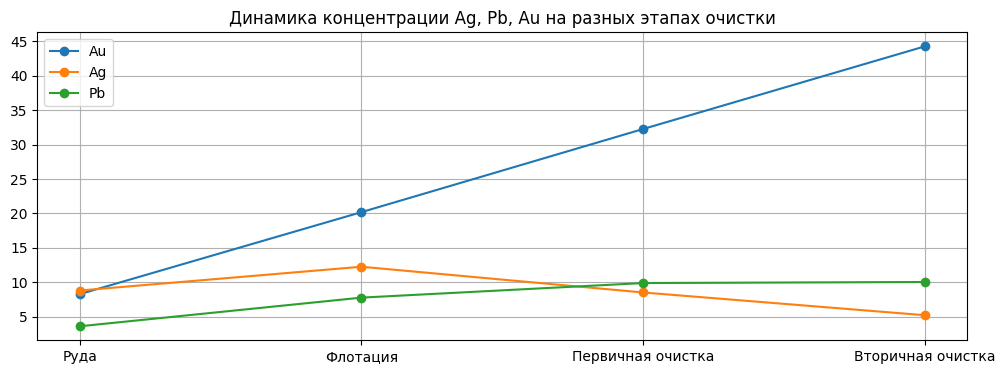

In [18]:
au = df_full[['rougher.input.feed_au','rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']].mean()
ag = df_full[['rougher.input.feed_ag','rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']].mean()
pb = df_full[['rougher.input.feed_pb','rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']].mean()
au.plot(style='-o', grid=True, figsize=(12,4), label='Au')
ag.plot(style='-o', grid=True, figsize=(12,4), label='Ag')
pb.plot(style='-o', grid=True, figsize=(12,4), label='Pb')

plt.title('Динамика концентрации Ag, Pb, Au на разных этапах очистки')
plt.xticks([0, 1, 2, 3], ['Руда', 'Флотация', 'Первичная очистка', 'Вторичная очистка'])
plt.legend()
plt.show()

Наблюдается уверенный рост концентрации золота, снижение концентрации серебра, а также небольшое увеличение концентрации свинца.

### Распределение размеров гранул сырья на тестовой и обучающей выборках

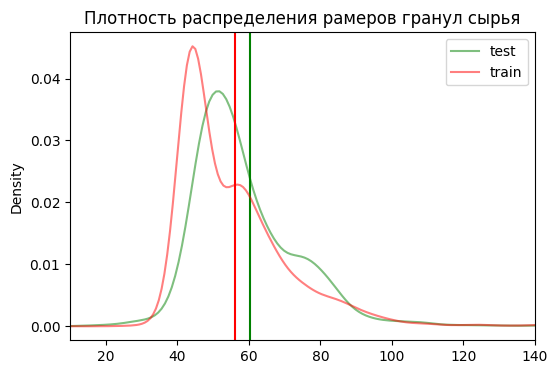

In [19]:
def show_kde(column, bins, range):
    test = df_train[column]
    train = df_test[column]
    test.plot(kind='kde', alpha=.5, label='test', color='green', figsize=(6, 4))
    plt.axvline(test.mean(), color ='green')
    train.plot(kind='kde', alpha=.5, label='train', color='red')
    plt.axvline(train.mean(), color ='red')
    plt.legend(loc='upper right')
    plt.xlim(range)
    plt.title('Плотность распределения рамеров гранул сырья')
    plt.show()


show_kde('rougher.input.feed_size', 200, (10, 140))

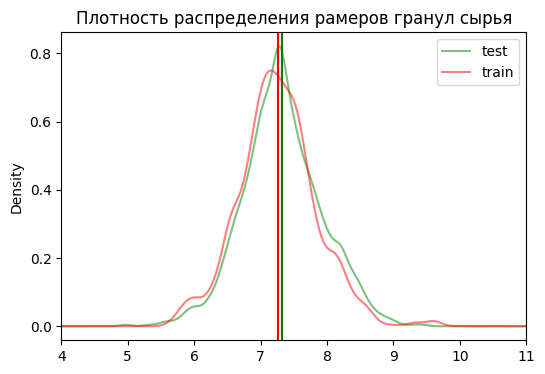

In [20]:
show_kde('primary_cleaner.input.feed_size', 100, (4, 11))

Исходное сырье имеют похожие распределения на тренировочной и тестовой выборках, с близкими средними, а после флотации распределения становятся почти равными, а значит тестовая выборка подходит для проверки.

### Суммарна концентрация на разных этапах

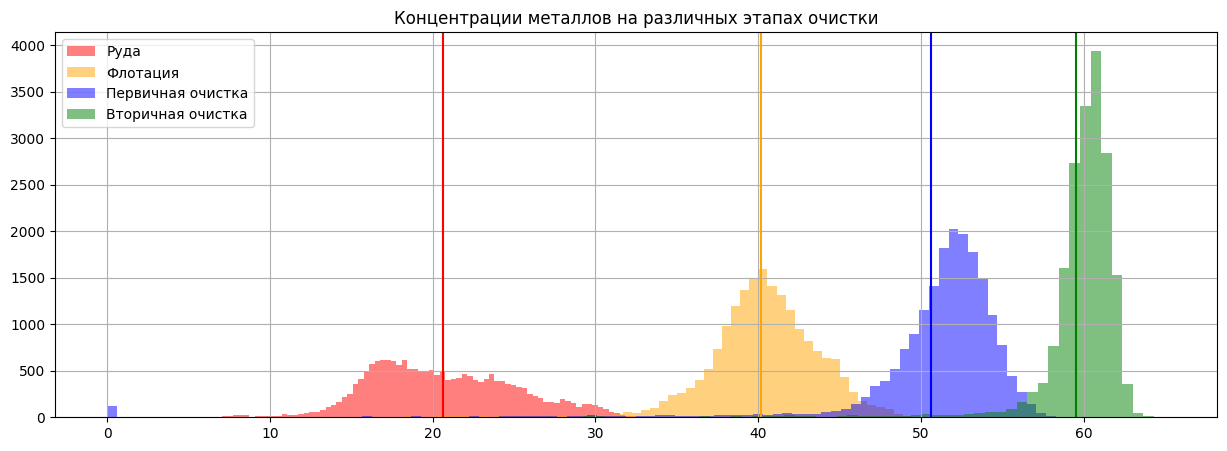

In [21]:
ore = df_full[[
    'rougher.input.feed_ag',
    'rougher.input.feed_au',
    'rougher.input.feed_pb']].sum(axis=1)

rougher_out = df_full[[
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_au',
    'rougher.output.concentrate_pb']].sum(axis=1)

primary_out = df_full[[
    'primary_cleaner.output.concentrate_ag',
    'primary_cleaner.output.concentrate_au',
    'primary_cleaner.output.concentrate_pb']].sum(axis=1)

final = df_full[[
    'final.output.concentrate_ag',
    'final.output.concentrate_au',
    'final.output.concentrate_pb']].sum(axis=1)

ore.hist(bins=100, alpha=.5, label='Руда', color='red')
rougher_out.hist(bins=100, alpha=.5, label='Флотация', color='orange')
primary_out.hist(bins=100, alpha=.5, label='Первичная очистка', color='blue')
final.hist(bins=100, alpha=.5, label='Вторичная очистка', color='green', figsize=(15, 5))
plt.axvline(ore.mean(), color ='red')
plt.axvline(rougher_out.mean(), color ='orange')
plt.axvline(primary_out.mean(), color ='blue')
plt.axvline(final.mean(), color ='green')
plt.legend(loc='upper left')
plt.title('Концентрации металлов на различных этапах очистки')
plt.show()

Наблюдается заметное увеличение концентрации и уменьшение ширины распределения на каждом этапе очистки.  
Пик около нуля наблюдается пик. Так как нули удалены, то посмотрим, что это за значения.

In [22]:
primary_out[primary_out < 1].sample(5)

date
2018-06-29 00:59:59    0.03
2018-08-10 07:59:59    0.03
2018-06-29 14:59:59    0.03
2018-05-03 17:59:59    0.03
2018-08-09 08:59:59    0.03
dtype: float64

Значения концентраций не нулевые, но крайне низкие, что не может соответствовать реальным данным. Посмотрим концентрации для этих записей на других этапах.

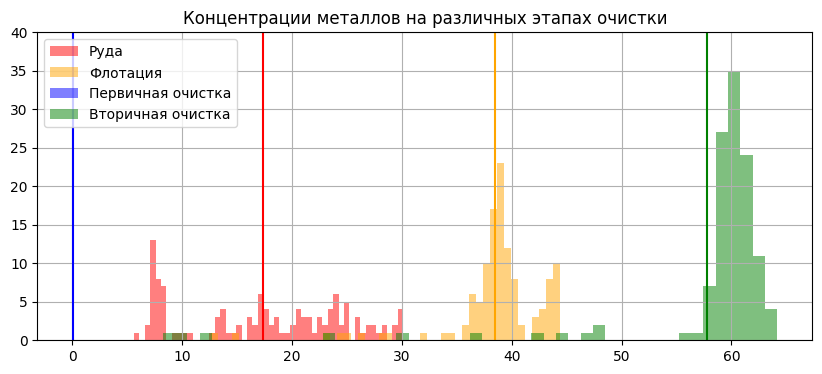

In [23]:
rows = primary_out < 1
ore[rows].hist(bins=50, alpha=.5, label='Руда', color='red')
rougher_out[rows].hist(bins=50, alpha=.5, label='Флотация', color='orange')
primary_out[rows].hist(bins=50, alpha=.5, label='Первичная очистка', color='blue')
ax = final[rows].hist(bins=50, alpha=.5, label='Вторичная очистка', color='green', figsize=(10, 4))
ax.set_ylim([0, 40])
plt.axvline(ore[rows].mean(), color ='red')
plt.axvline(rougher_out[rows].mean(), color ='orange')
plt.axvline(primary_out[rows].mean(), color ='blue')
plt.axvline(final[rows].mean(), color ='green')
plt.legend(loc='upper left')
plt.title('Концентрации металлов на различных этапах очистки')
plt.show()

Концентрация в руде немного ниже, но все равно сильно выше нуля, остальные концентрации в норме, что говорит об ошибке в записях для первичной очистки. Так как записи концентрации после первичной очистки не используются для обучения моделей и расчета рекавери, то можно их оставить.

## Модель

### sMAPE scorer

Для оценки будем использовать sMAPE. Сделаем scorer.

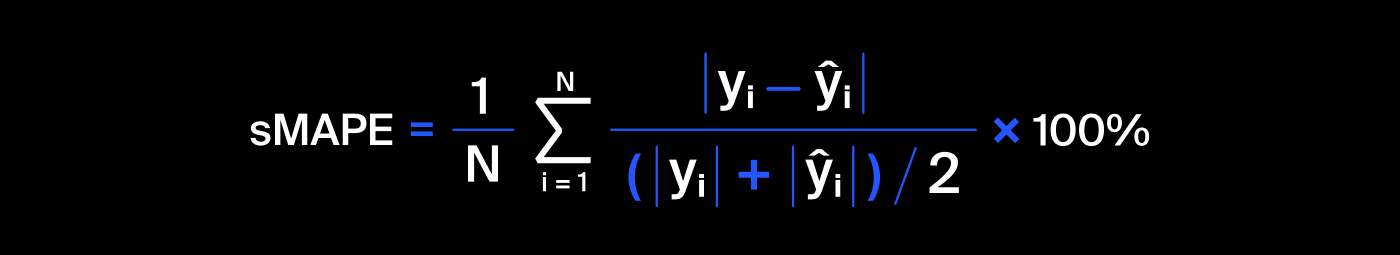

In [24]:
def sMAPE(target, predict):
    return (abs(target - predict) / ((abs(target) + abs(predict)) / 2)).mean() * 100

def final_sMAPE(smape_rougher, smape_final):
    return .25 * smape_rougher + .75 * smape_final

In [25]:
scorer = make_scorer(sMAPE, greater_is_better=False)

### Перебор гиперпараметров моделей

In [26]:
model_ridge = make_pipeline(MinMaxScaler(), Ridge())
model_en = make_pipeline(MinMaxScaler(), ElasticNet())
model_svr = make_pipeline(MinMaxScaler(), SVR())

params_svr = {
    'svr__C': [.1, .2],
    'svr__kernel': ['linear'],
    'svr__gamma': [.1, 10],
    'svr__degree': [1, 2],
    'svr__epsilon': [.5, 1]
}

params_ridge = {
    'ridge__alpha': range(0, 500, 20),
    'ridge__max_iter': [1000],
    'ridge__tol': [.0001]
}

params_en = {
    'elasticnet__alpha': [.01, .1, 1],
    'elasticnet__l1_ratio': [.5, .95],
}

In [27]:
def train_model(name, model, param, train, train_target, test, test_target):
    print('\n', name, '\n')
    grid_cv = GridSearchCV(model, param_grid=param, cv=5, scoring=scorer)
    grid_cv.fit(train, train_target)
    print(f'sMAPE {abs(grid_cv.best_score_):.3f}')
    print('Лучшие параметры', grid_cv.best_params_)
    test_predict = grid_cv.predict(test)
    test_sMAPE = sMAPE(test_target, test_predict)
    print(f'sMAPE на тестовой выборке {test_sMAPE:.3f}\n')
    return grid_cv, test_sMAPE


In [28]:
%%time
grid_rougher_en, rougher_en_sMAPE = train_model("ElasticNet rougher", model_en, params_en, train_rougher, train_target_rougher, test_rogher, test_target_rougher)
grid_rougher_ridge, rougher_ridge_sMAPE = train_model("Ridge rougher", model_ridge, params_ridge, train_rougher, train_target_rougher, test_rogher, test_target_rougher)
grid_rougher_svr, rougher_svr_sMAPE = train_model("SVR rougher", model_svr, params_svr, train_rougher, train_target_rougher, test_rogher, test_target_rougher)

grid_final_en, final_en_sMAPE = train_model("ElasticNet final", model_en, params_en, train_final, train_target_final, test_final, test_target_final)
grid_final_ridge, final_ridge_sMAPE = train_model("Ridge final", model_ridge, params_ridge, train_final, train_target_final, test_final, test_target_final)
grid_final_svr, final_svr_sMAPE = train_model("SVR final", model_svr, params_svr, train_final, train_target_final, test_final, test_target_final)


 ElasticNet rougher 

sMAPE 6.181
Лучшие параметры {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.5}
sMAPE на тестовой выборке 4.345


 Ridge rougher 

sMAPE 6.144
Лучшие параметры {'ridge__alpha': 120, 'ridge__max_iter': 1000, 'ridge__tol': 0.0001}
sMAPE на тестовой выборке 4.324


 SVR rougher 

sMAPE 6.244
Лучшие параметры {'svr__C': 0.2, 'svr__degree': 1, 'svr__epsilon': 1, 'svr__gamma': 0.1, 'svr__kernel': 'linear'}
sMAPE на тестовой выборке 4.156


 ElasticNet final 

sMAPE 9.259
Лучшие параметры {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.95}
sMAPE на тестовой выборке 7.096


 Ridge final 

sMAPE 9.428
Лучшие параметры {'ridge__alpha': 300, 'ridge__max_iter': 1000, 'ridge__tol': 0.0001}
sMAPE на тестовой выборке 7.292


 SVR final 

sMAPE 9.388
Лучшие параметры {'svr__C': 0.1, 'svr__degree': 1, 'svr__epsilon': 1, 'svr__gamma': 0.1, 'svr__kernel': 'linear'}
sMAPE на тестовой выборке 7.376

CPU times: user 18min 10s, sys: 31.1 s, total: 18min 41s
Wall time: 18min 

Для оценки рекавери после флотации лучше всего себя показала SVR модель с sMAPE на тестовой выборке 4.156  
Параметры SVR  C: 0.2, degree: 1, epsilon: 1, gamma: 0.1, kernel: 'linear'  

Для общей рекавери лучшие показетели у ElasticNet с sMAPE на тестовой выборке 7.1   
Параметры ElasticNet alpha: 0.1, l1_ratio: 0.95

Посчитаем итоговый sMAPE

In [29]:
final_sMAPE(rougher_svr_sMAPE, final_en_sMAPE)

6.361134515628257

### Проверка

Сравним результат с константной моделью

In [30]:
dummy_rougher = DummyRegressor(strategy='median')
dummy_final = DummyRegressor(strategy='median')
dummy_rougher.fit(train_rougher, train_target_rougher)
dummy_final.fit(train_final, train_target_final)
rougher = dummy_rougher.predict(test_rogher)
final = dummy_final.predict(test_final)

print(f'sMAPE флотации {sMAPE(test_target_rougher, rougher):.3f}\n',
      f'sMAPE очистки {sMAPE(test_target_final, final):.3f}')
final_smape = final_sMAPE(sMAPE(test_target_rougher, rougher), sMAPE(test_target_final, final))
print(f'итоговая sMAPE {final_smape:.3f}')

sMAPE флотации 4.809
 sMAPE очистки 8.223
итоговая sMAPE 7.369


Результат хуже чем у полученой модели.

## Вывод

Сделана проверка рассчета рекавери после флотации. Расходление в пределах погрешности float переменных, рассчет верен.

Исследована средняя концентрация металлов на раэличных этапах очистки.  
Наблюдается уверенный рост концентрации золота, снижение концентрации серебра, а также небольшое увеличение концентрации свинца.

Исследовано распределение размеров гранул сырья в обучающей и тестовой выборках.  
Распределение для руды близкое, после флотации распределения становятся почти идентичными.

Исследованы распределения суммарной концентрации металлов.  
Наблюдается заметное увеличение концентрации и уменьшение ширины распределения на каждом этапе очистки.

Получены модели для предсказания значения рекавери со следующими параметрами:  
Рекавери после флотации модель Epsilon-Support Vector Regression с sMAPE на тестовой выборке 4.156  
Параметры SVR  C: 0.2, degree: 1, epsilon: 1, gamma: 0.1, kernel: 'linear'  
Общяя рекавери модель ElasticNet с sMAPE на тестовой выборке 7.1  
Параметры ElasticNet alpha: 0.1, l1_ratio: 0.95  
Итоговый sMAPE 6.36

